<a href="https://colab.research.google.com/github/judem-21/Natural-Language-Processing/blob/main/Image%20Captioning/ImgCaptioning_fin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ImCAP

#### Libraries

In [ ]:
import os
import pandas as pd
import torch,torchvision
from torch.utils.data import Dataset,DataLoader
from skimage import io
import spacy
from torch.utils.tensorboard import SummaryWriter
from torch.nn.utils.rnn import pad_sequence
from PIL import Image
import torch.nn as nn
#from utils_save_checkpoint, load_checkpoint, print_examples
#import torch.nn as nn
#import torchvision.transforms as transforms

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms as transforms

In [ ]:
#mounting google drive to access and store images
num_samples=7168
from google.colab import drive
drive.mount('/content/drive')
!python -m spacy download en
spacy_eng = spacy.load("en_core_web_sm")

#### Dataset

In [ ]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

In [ ]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, num_samples,transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file).to_numpy()
        self.transform = transform
        self.num_samples=num_samples

        self.image_captions = {}
        #counter=0
        for row in range(0,num_samples):
            #if counter==num_samples: break
            image_id = self.df[row][0]
            caption = self.df[row][1]
            '''if image_id not in self.image_captions:
                self.image_captions[image_id] = []'''
            self.image_captions[image_id]=caption
            #counter+=1

        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.df[:num_samples,1])

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        img_id = list(self.image_captions.keys())[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        selected_caption = self.image_captions[img_id]
        #selected_caption = random.choice(captions)

        numericalized_caption = [
            self.vocab.stoi["<SOS>"]] + self.vocab.numericalize(selected_caption) + [self.vocab.stoi["<EOS>"]]

        return img, torch.tensor(numericalized_caption)

In [ ]:
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets

In [ ]:
def get_loader(
    root_folder,
    annotation_file,
    transform,num_samples=2048,
    batch_size=32,
    num_workers=8,
    shuffle=True,
    pin_memory=True,
):
    dataset = FlickrDataset(root_folder, annotation_file, transform=transform,num_samples=num_samples)

    pad_idx = dataset.vocab.stoi["<PAD>"]

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )

    return loader, dataset

#### Model

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN
        self.resnet50 = torchvision.models.resnet50(pretrained=True)
        self.resnet50.fc = nn.Linear(self.resnet50.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        features = self.resnet50(images)

        for name, param in self.resnet50.named_parameters():
            if "fc.weight" in name or "fc.bias" in name:
                param.requires_grad = True
            else:
                param.requires_grad = self.train_CNN

        return self.dropout(self.relu(features))

In [ ]:
class DecoderRNN(nn.Module):
  def __init__(self,embed_size, hidden_size, vocab_size, num_layers):
    super(DecoderRNN,self).__init__()
    self.embed_size=embed_size
    self.hidden_size = hidden_size
    self.vocab_size = vocab_size

    self.embed = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.embed_size)
    # lstm cell
    self.lstm = nn.LSTM(input_size=embed_size, hidden_size=hidden_size,num_layers=num_layers)

    self.linear=nn.Linear(hidden_size,vocab_size)
    self.softmax=nn.Softmax(dim=2)
    self.dropout=nn.Dropout(p=0.5)

  def forward(self,features,captions):
    embeddings=self.dropout(self.embed(captions))
    embeddings=torch.cat((features.unsqueeze(0),embeddings),dim=0)
    hiddens,_=self.lstm(embeddings)
    outputs=self.linear(hiddens)
    return outputs

In [ ]:
class EnctoDec(torch.nn.Module):
  def __init__(self,embed_size,hidden_size,vocab_size,num_layers):
    super(EnctoDec, self).__init__()
    self.encoder=EncoderCNN(embed_size)
    self.decoder=DecoderRNN(embed_size,hidden_size,vocab_size,num_layers)


  def forward(self,images,captions):
    features=self.encoder(images)
    outputs=self.decoder(features,captions)
    return outputs

  def caption_image(self,image,vocabulary,max_length=50):
    result_caption=[]

    with torch.no_grad():
      x=self.encoder(image).unsqueeze(0)
      states=None
      for _ in range(0,max_length):
        hiddens,states=self.decoder.lstm(x,states)
        output=self.decoder.linear(hiddens.unsqueeze(0))
        #print(f'output of type:{type(output)} of dimension:{output.shape}')
        predicted=output.squeeze(0)[0].cpu().detach().argmax(dim=1)
        #print(f'predicted of type:{type(predicted)} of dimension:{predicted.shape}')
        result_caption.append(predicted.item())
        x=self.decoder.embed(predicted).unsqueeze(0)

        if vocabulary.itos[predicted.item()] =='<EOS>': break

    return [vocabulary.itos[idx] for idx in result_caption]

#### Training and Model Initilialisation

In [ ]:
transform=transforms.Compose([transforms.Resize((356,356)),
                                transforms.RandomCrop((299,299)),
                                transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_loader, dataset = get_loader(root_folder="/content/drive/MyDrive/archive/Images",annotation_file="/content/drive/MyDrive/archive/newcaptions.txt",num_samples=4096,transform=transform,num_workers=2)

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#hyperparams
path='/content/drive/MyDrive/imcap_model'
new_path='/content/drive/MyDrive/imcap_params'
embed_size,hidden_size=256,256
vocab_size=len(dataset.vocab)
num_layers=1
learning_rate=3e-4
num_epochs=50
model = EnctoDec(embed_size,hidden_size,vocab_size,num_layers).to(device)
min_loss=torch.load('/content/drive/MyDrive/imcap_params.pth',map_location=device)['loss']
model.load_state_dict(torch.load('/content/drive/MyDrive/imcap_model.pth',map_location=device))
criterion=torch.nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi['<PAD>'])
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [ ]:
print(f'Vocab size is: {len(dataset.vocab)}')

Vocab size is: 796


In [ ]:
def save_checkpoint(epoch,model,loss,optimizer,path):
  if path[-4:]!='.pth': checkpoint_path=path+'.pth'
  else: checkpoint_path=path
  torch.save({'epoch':epoch,
      'model_state_dict':model.state_dict(),
      'optimizer_state_dict':optimizer.state_dict(),
              'loss':loss
  },checkpoint_path)

In [ ]:
model.train()
c=0
chk=0
loss_list=[]
num_batches=len(train_loader)
for epoch in range(1,num_epochs+1):
  batch_losses=[]
  print(f'Epoch {epoch} begins:-')
  for idx,(imgs,captions) in enumerate(train_loader):
    imgs=imgs.to(device)
    captions=captions.to(device)

    outputs=model(imgs,captions[:-1])
    if c==0:
      print('working!!',outputs.shape,captions.shape)
      print(f'Type epoch and idx:{type(epoch)}&{type(idx)}')
      c+=1
    loss=criterion(outputs.reshape(-1,outputs.shape[2]),captions.reshape(-1))

    batch_losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (idx+1) % 20 == 0:
      lss=batch_losses[-1]
      print(f'Epoch [{epoch}/{num_epochs}], Step [{idx+1}/{num_batches}], Loss: {lss:.4f}')
      if lss<min_loss:
        min_loss=lss
        save_checkpoint(epoch,model,lss,optimizer,new_path)
        torch.save(model.state_dict(),path+'.pth')
        print(f'Improved Model saved at {path}')
      print()
      #if lss<=2.15: chk=1;break

  loss_list.append(np.mean(batch_losses))
  #if chk==1: print('Early break off due to less loss!!');break
  print(f'Epoch {epoch} done!!\n\n')

Epoch 1 begins:-


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


working!! torch.Size([19, 32, 796]) torch.Size([19, 32])
Type epoch and idx:<class 'int'>&<class 'int'>
Epoch [1/50], Step [20/128], Loss: 1.9223
Improved Model saved at /content/drive/MyDrive/imcap_model

Epoch [1/50], Step [40/128], Loss: 1.8486
Improved Model saved at /content/drive/MyDrive/imcap_model

Epoch [1/50], Step [60/128], Loss: 1.9304

Epoch [1/50], Step [80/128], Loss: 2.0416

Epoch [1/50], Step [100/128], Loss: 1.9586

Epoch [1/50], Step [120/128], Loss: 1.9423



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1 done!!


Epoch 2 begins:-
Epoch [2/50], Step [20/128], Loss: 1.9376

Epoch [2/50], Step [40/128], Loss: 1.8083
Improved Model saved at /content/drive/MyDrive/imcap_model

Epoch [2/50], Step [60/128], Loss: 1.9274

Epoch [2/50], Step [80/128], Loss: 2.0972

Epoch [2/50], Step [100/128], Loss: 1.9780

Epoch [2/50], Step [120/128], Loss: 1.9100

Epoch 2 done!!


Epoch 3 begins:-
Epoch [3/50], Step [20/128], Loss: 1.8848

Epoch [3/50], Step [40/128], Loss: 1.8472

Epoch [3/50], Step [60/128], Loss: 1.9209

Epoch [3/50], Step [80/128], Loss: 1.8953

Epoch [3/50], Step [100/128], Loss: 1.8826

Epoch [3/50], Step [120/128], Loss: 1.8804

Epoch 3 done!!


Epoch 4 begins:-
Epoch [4/50], Step [20/128], Loss: 1.7620
Improved Model saved at /content/drive/MyDrive/imcap_model

Epoch [4/50], Step [40/128], Loss: 1.8450

Epoch [4/50], Step [60/128], Loss: 1.8547

Epoch [4/50], Step [80/128], Loss: 1.9222

Epoch [4/50], Step [100/128], Loss: 1.9424

Epoch [4/50], Step [120/128], Loss: 1.9517



#### Testing and Evaluation

In [ ]:
batch_idx=5
for idx,(images,captions) in enumerate(train_loader):
  if idx==batch_idx:break
outputs=model(images.cuda(),captions.cuda())

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
for chk_idx in range(32):
  '''image=images[chk_idx].permute(1,2,0).numpy()*0.5+0.5
  plt.imshow(image)'''

  print(f'Index: {chk_idx}')
  print('Expected Caption:',end=' ')
  for ch_idx in captions[:,chk_idx]:
    word=dataset.vocab.itos[ch_idx.item()]
    print(word,end=' ')
    if word=='<EOS>': break

  print('\nOutput Caption:',end=' ')
  for ch_idx in outputs.argmax(dim=2)[:,chk_idx]:
    word=dataset.vocab.itos[ch_idx.item()]
    print(word,end=' ')
    if word=='<EOS>': break
  print('\n')

Index: 0
Expected Caption: <SOS> a four wheel <UNK> car is driving through the mud . <EOS> 
Output Caption: <SOS> a group wheel <UNK> is is driving through the mud . <EOS> 

Index: 1
Expected Caption: <SOS> a guy with a nose <UNK> . <EOS> 
Output Caption: <SOS> a man with a <UNK> <UNK> on <EOS> 

Index: 2
Expected Caption: <SOS> a boy in a yellow shirt is walking on a beach holding a surfboard . <EOS> 
Output Caption: <SOS> a boy in a red shirt is jumping on a rock with a surfboard . <EOS> 

Index: 3
Expected Caption: <SOS> a man in jeans lying down on a pole outdoors . <EOS> 
Output Caption: <SOS> a boy in a is on a a cliff . . <EOS> 

Index: 4
Expected Caption: <SOS> a man in a black t - shirt looking down as he holds a drink . <EOS> 
Output Caption: <SOS> a man in a black shirt - shirt is down while he holds a drink . <EOS> 

Index: 5
Expected Caption: <SOS> the three dogs are running down a snowy track . <EOS> 
Output Caption: <SOS> a two dogs are in through a river hill . <EOS> 



Batch no.:6
Expected Caption: <SOS> a man and a woman in white shirts and dark glasses smiling . <EOS> 
Output Caption: <SOS> a man in a woman in a <UNK> and black glasses . . <EOS> 

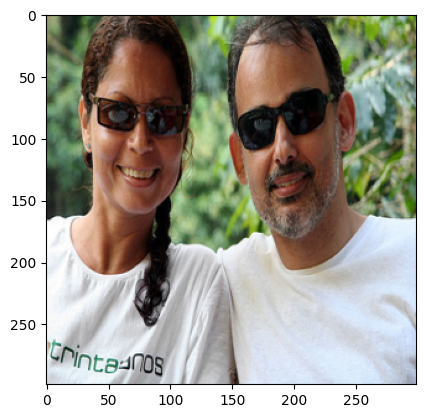

In [ ]:
print(f'Batch no.:{batch_idx+1}')
chk_idx=24
image=images[chk_idx].permute(1,2,0).numpy()*0.5+0.5
plt.imshow(image)
print('Expected Caption:',end=' ')
for ch_idx in captions[:,chk_idx]:
  word=dataset.vocab.itos[ch_idx.item()]
  print(word,end=' ')
  if word=='<EOS>': break

print('\nOutput Caption:',end=' ')
for ch_idx in outputs.argmax(dim=2)[:,chk_idx]:
  word=dataset.vocab.itos[ch_idx.item()]
  print(word,end=' ')
  if word=='<EOS>': break


In [ ]:
plt.plot(range(1,num_epochs+1),loss_list)
plt.xlabel('Epoch no.')
plt.ylabel('Loss')
plt.title('Loss Curve')